In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os
import numpy as np

Procesando 80 archivos...


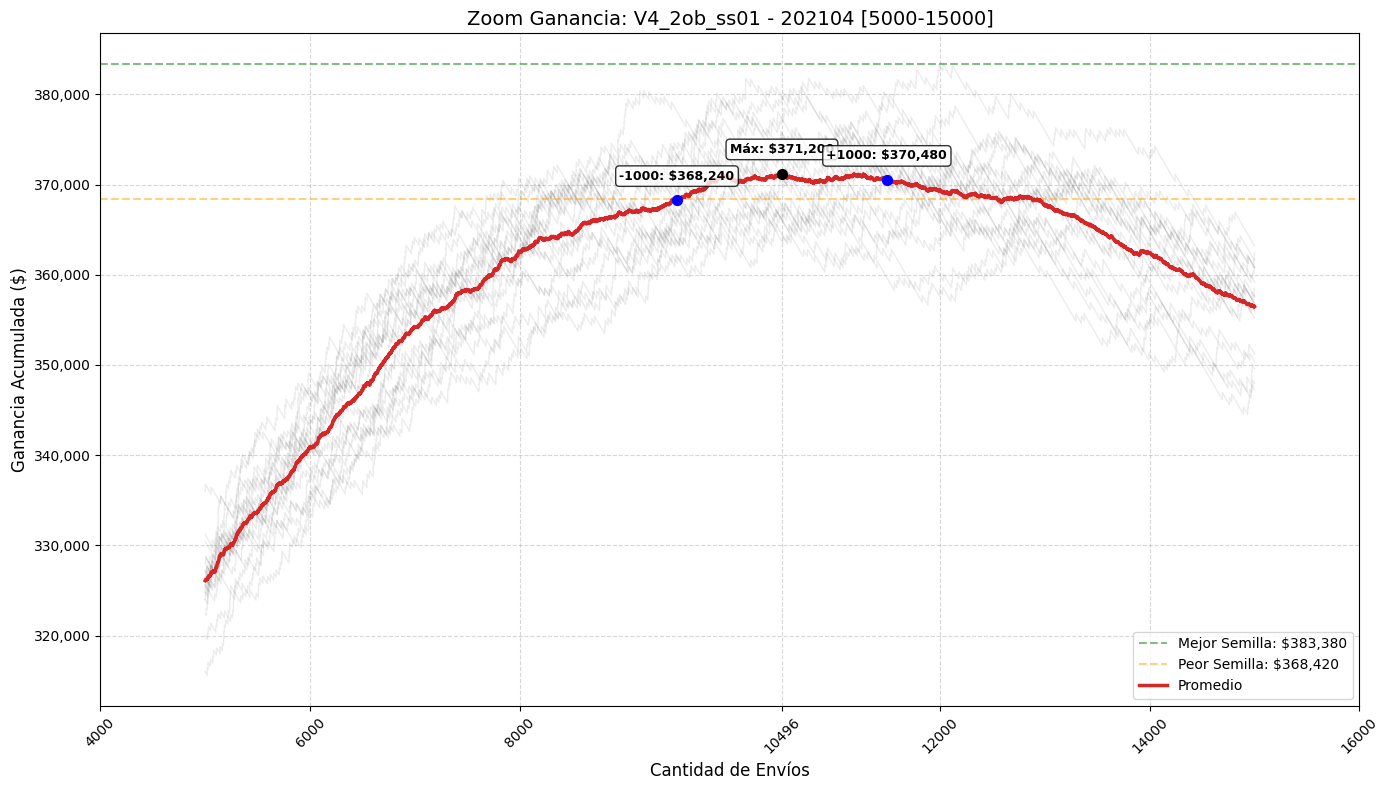

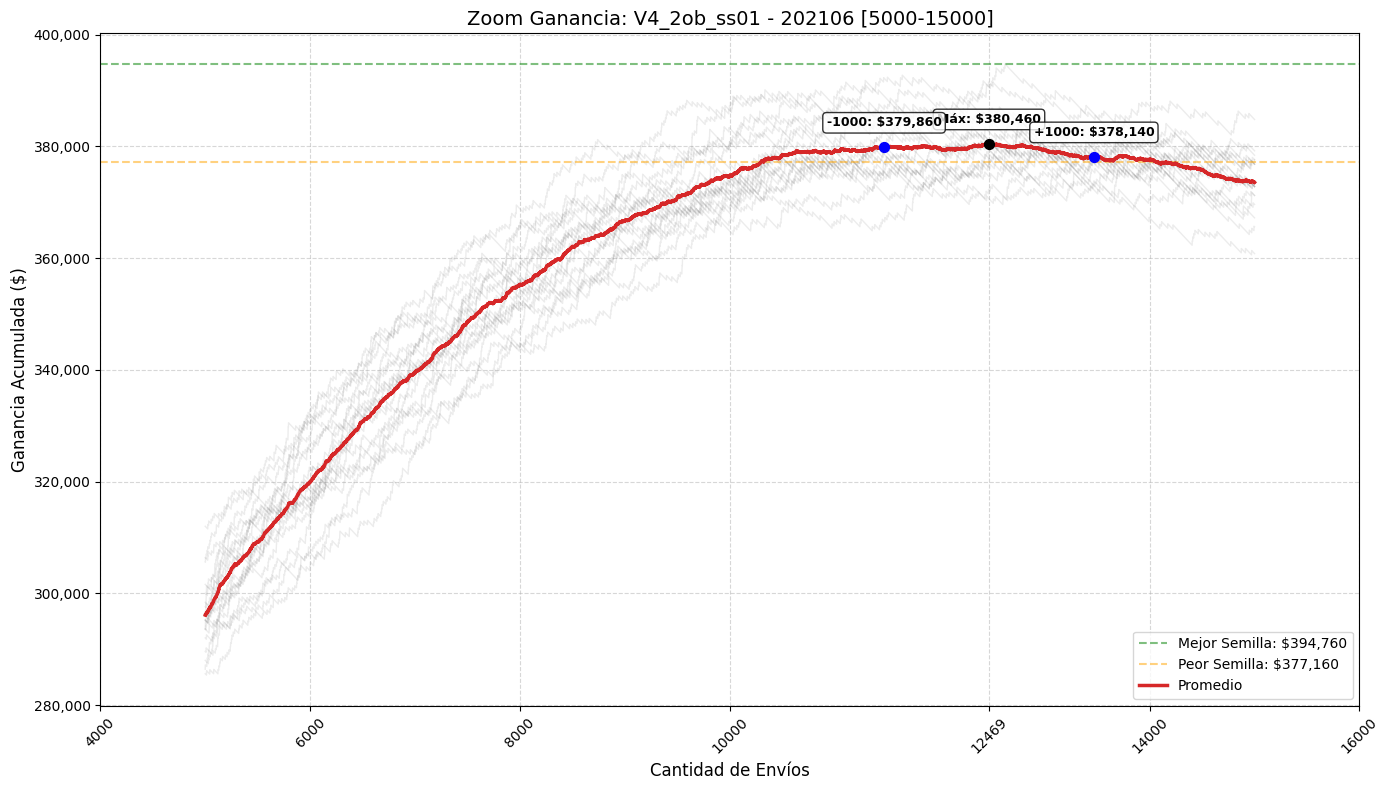

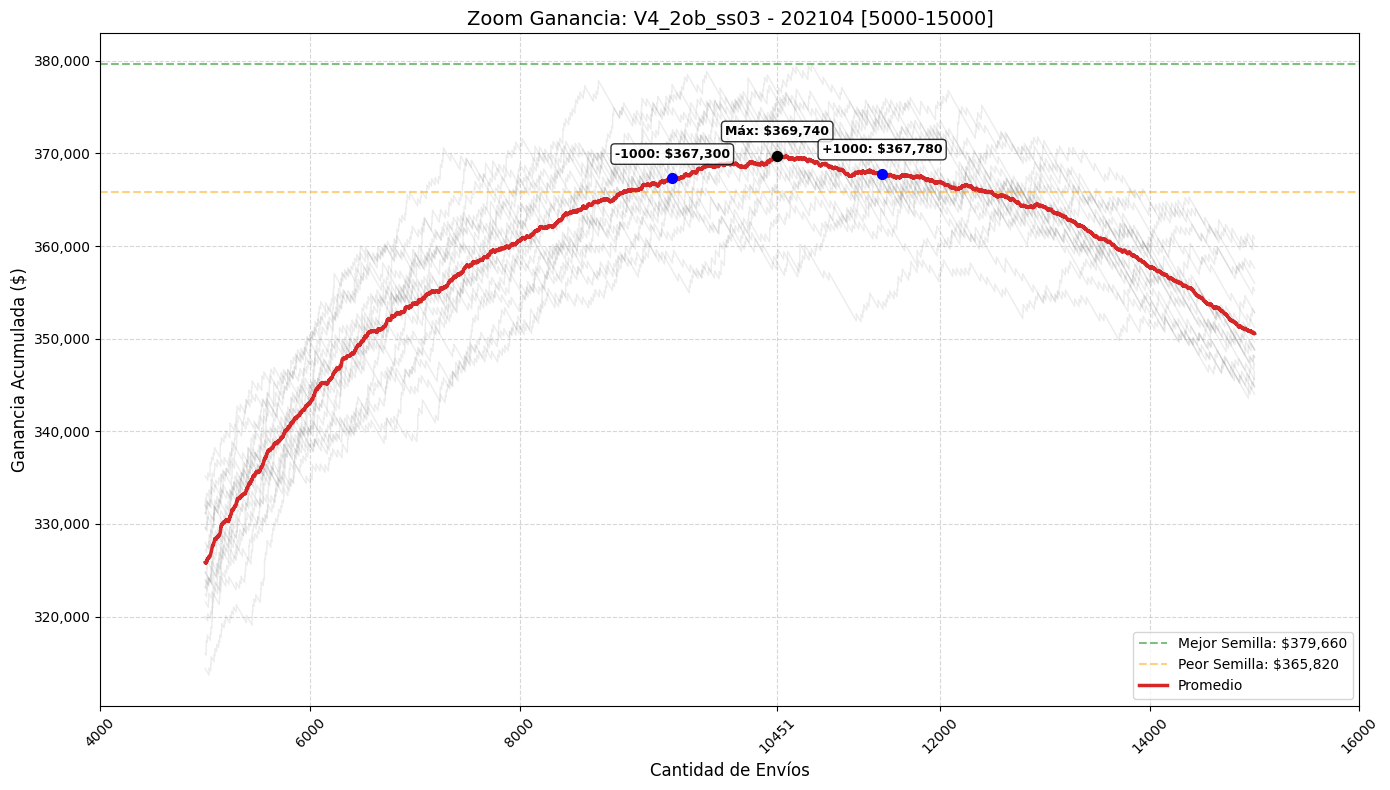

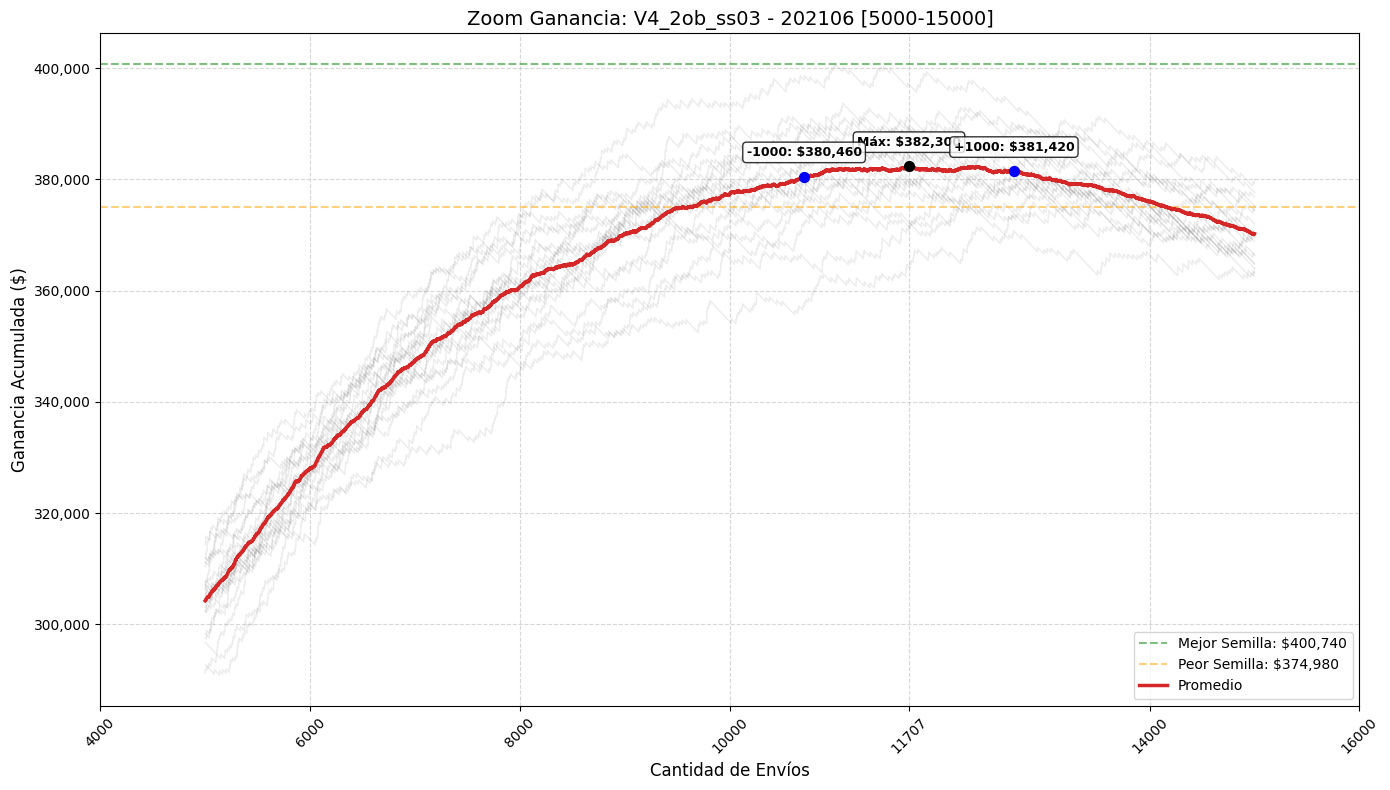

In [9]:
# ================= CONFIGURACIÓN =================
RUTA_CARPETA = './colaborativos' 

# Parámetros de negocio
GANANCIA_UNITARIA = 780
COSTO_UNITARIO = -20

# --- LÍMITES DE VISUALIZACIÓN (EL ZOOM) ---

# Eje X: Cantidad de Envíos (Clientes)
X_LIM_MIN = 5000    # Desde dónde empieza el gráfico
X_LIM_MAX = 15000   # Hasta dónde llega

# Eje Y: Ganancia ($)
# Puedes poner números exactos (ej: 8000000) o None para que sea automático
Y_LIM_MIN = 200 
Y_LIM_MAX = None 

PATRON_REGEX = r"predicciones_test_ordenadas_Compe_02_(.*?)_mes_(\d+)_semilla_modelo_(\d+)"
# =================================================

def formatear_moneda(valor):
    return f"${int(valor):,}"

def procesar_archivos():
    archivos = glob.glob(os.path.join(RUTA_CARPETA, "*.csv"))
    if not archivos:
        print("No se encontraron archivos .csv")
        return

    datos_agrupados = {}
    print(f"Procesando {len(archivos)} archivos...")

    for archivo in archivos:
        nombre_archivo = os.path.basename(archivo)
        match = re.search(PATRON_REGEX, nombre_archivo)
        if match:
            llave = (match.group(1), match.group(2)) # (Modelo, Mes)
            
            try:
                df = pd.read_csv(archivo)
                df['ganancia'] = np.where(df['clase_peso'] == 3, GANANCIA_UNITARIA, COSTO_UNITARIO)
                df['ganancia_acumulada'] = df['ganancia'].cumsum()
                df['envios'] = np.arange(1, len(df) + 1)
                
                # OPTIMIZACIÓN:
                # Recortamos los datos un poco más allá del límite máximo visual 
                # para no cargar memoria innecesaria, pero suficiente para calcular tendencias.
                df_plot = df[df['envios'] <= (X_LIM_MAX + 2000)][['envios', 'ganancia_acumulada']].copy()
                
                if llave not in datos_agrupados:
                    datos_agrupados[llave] = []
                datos_agrupados[llave].append(df_plot)
            except Exception as e:
                print(f"Error leyendo {nombre_archivo}: {e}")

    # --- GRAFICACIÓN ---
    for (modelo, mes), lista_dfs in datos_agrupados.items():
        fig, ax = plt.subplots(figsize=(14, 8))
        
        maximos_por_semilla = []

        # 1. Curvas individuales
        for df_semilla in lista_dfs:
            # Filtramos visualmente solo lo que está dentro del rango X para que el plot no sea pesado
            mask = (df_semilla['envios'] >= X_LIM_MIN) & (df_semilla['envios'] <= X_LIM_MAX)
            segmento = df_semilla[mask]
            
            if not segmento.empty:
                ax.plot(segmento['envios'], segmento['ganancia_acumulada'], 
                        color='gray', alpha=0.15, linewidth=1)
            
            # Guardamos el máximo global de esta semilla (aunque esté fuera del zoom, es el dato real)
            maximos_por_semilla.append(df_semilla['ganancia_acumulada'].max())

        # 2. Líneas de Rango (Max-Max y Min-Max)
        if maximos_por_semilla:
            max_de_maximos = max(maximos_por_semilla)
            min_de_maximos = min(maximos_por_semilla)
            
            ax.axhline(y=max_de_maximos, color='green', linestyle='--', alpha=0.5, label=f'Mejor Semilla: {formatear_moneda(max_de_maximos)}')
            ax.axhline(y=min_de_maximos, color='orange', linestyle='--', alpha=0.5, label=f'Peor Semilla: {formatear_moneda(min_de_maximos)}')

        # 3. Curva Promedio
        if lista_dfs:
            df_concat = pd.concat(lista_dfs)
            df_promedio = df_concat.groupby('envios')['ganancia_acumulada'].mean()
            
            # Recortamos el promedio para el plot
            df_prom_plot = df_promedio[(df_promedio.index >= X_LIM_MIN) & (df_promedio.index <= X_LIM_MAX)]
            
            ax.plot(df_prom_plot.index, df_prom_plot.values, color='#D62728', linewidth=2.5, label='Promedio')

            # --- PUNTOS CLAVE (Max, -1000, +1000) ---
            # Calculamos el óptimo sobre TODOS los datos disponibles (no solo el zoom) para exactitud
            x_optimo = df_promedio.idxmax()
            y_optimo = df_promedio.max()
            
            puntos_interes = [x_optimo]
            etiquetas = [f"Máx: {formatear_moneda(y_optimo)}"]
            colores = ['black']

            for offset in [-1000, 1000]:
                x_vecino = x_optimo + offset
                if x_vecino in df_promedio.index:
                    y_vecino = df_promedio.loc[x_vecino]
                    puntos_interes.append(x_vecino)
                    etiquetas.append(f"{'+' if offset>0 else ''}{offset}: {formatear_moneda(y_vecino)}")
                    colores.append('blue')

            # Dibujamos los puntos solo si caen dentro del zoom definido
            for x, y, txt, col in zip(puntos_interes, [df_promedio.loc[p] for p in puntos_interes], etiquetas, colores):
                if X_LIM_MIN <= x <= X_LIM_MAX:
                    ax.scatter([x], [y], color=col, zorder=5, s=50)
                    ax.annotate(txt, (x, y), xytext=(0, 15), textcoords='offset points', 
                                ha='center', fontsize=9, fontweight='bold',
                                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

            # --- EJES Y TICKS ---
            
            # Aplicamos los límites definidos por el usuario
            ax.set_xlim(X_LIM_MIN, X_LIM_MAX)
            
            if Y_LIM_MIN is not None and Y_LIM_MAX is not None:
                ax.set_ylim(Y_LIM_MIN, Y_LIM_MAX)
            
            # Ticks personalizados en X
            ticks = list(ax.get_xticks())
            # Agregamos el óptimo si está en el rango
            if X_LIM_MIN <= x_optimo <= X_LIM_MAX:
                # Limpiamos ticks cercanos para que no se superponga
                ticks = [t for t in ticks if abs(t - x_optimo) > ((X_LIM_MAX - X_LIM_MIN)/15)]
                ticks.append(x_optimo)
                ticks.sort()
                ax.set_xticks(ticks)

            plt.xticks(rotation=45)

        # Formato final
        plt.title(f"Zoom Ganancia: {modelo} - {mes} [{X_LIM_MIN}-{X_LIM_MAX}]", fontsize=14)
        plt.xlabel("Cantidad de Envíos", fontsize=12)
        plt.ylabel("Ganancia Acumulada ($)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='lower right')
        
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    procesar_archivos()
